# Customer Behavior Analytics - Data Exploration

This notebook performs comprehensive exploratory data analysis on customer behavior data.

## Objectives
1. Load and explore customer data
2. Perform data quality assessment
3. Create initial visualizations
4. Generate summary statistics
5. Identify patterns and insights

## Table of Contents
1. [Environment Setup](#environment-setup)
2. [Data Loading](#data-loading)
3. [Data Overview](#data-overview)
4. [Data Quality Assessment](#data-quality-assessment)
5. [Exploratory Visualizations](#exploratory-visualizations)
6. [Summary Statistics](#summary-statistics)
7. [Key Insights](#key-insights)


## Environment Setup

First, let's import all necessary libraries for data analysis and visualization.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

# Set up plotting style
plt.style.use('default')  # Changed from 'seaborn-v0_8' to 'default' for compatibility
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")
print(f"🎨 Seaborn version: {sns.__version__}")

# Data generation functions (embedded to avoid import issues)
def get_sample_data(n_customers: int = 1000) -> pd.DataFrame:
    """Generate sample customer behavior data for analysis."""
    np.random.seed(42)  # For reproducible results
    random.seed(42)
    
    # Generate customer IDs
    customer_ids = [f"CUST_{i:04d}" for i in range(1, n_customers + 1)]
    
    # Generate demographic data
    ages = np.random.normal(45, 15, n_customers).astype(int)
    ages = np.clip(ages, 18, 80)  # Ensure reasonable age range
    
    genders = np.random.choice(['M', 'F', 'Other'], n_customers, p=[0.4, 0.5, 0.1])
    
    cities = np.random.choice([
        'Zurich', 'Geneva', 'Basel', 'Bern', 'Lausanne', 'Lucerne'
    ], n_customers)
    
    # Generate registration dates (spread over 2023)
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)
    date_range = (end_date - start_date).days
    
    registration_dates = [
        start_date + timedelta(days=random.randint(0, date_range))
        for _ in range(n_customers)
    ]
    
    # Generate behavioral data with realistic correlations
    # Higher age -> slightly higher spending
    age_factor = (ages - ages.mean()) / ages.std()
    
    # Generate total purchases (1-20, with some correlation to age)
    total_purchases = np.random.poisson(5, n_customers) + np.random.poisson(2, n_customers) * (1 + 0.1 * age_factor)
    total_purchases = np.clip(total_purchases, 1, 20).astype(int)
    
    # Generate total spent (correlated with purchases and age)
    base_spending = 50 + 30 * total_purchases + 2 * ages + np.random.normal(0, 50, n_customers)
    total_spent = np.maximum(base_spending, 0.5)  # Minimum $0.50
    
    # Generate session data
    avg_session_duration = np.random.exponential(10, n_customers) + 5
    avg_session_duration = np.clip(avg_session_duration, 0.5, 35)
    
    page_views_per_session = np.random.poisson(8, n_customers) + np.random.poisson(3, n_customers)
    page_views_per_session = np.clip(page_views_per_session, 2, 25).astype(int)
    
    # Bounce rate (inverse relationship with session duration)
    bounce_rate = np.random.beta(2, 5, n_customers) * (1 - 0.3 * (avg_session_duration / avg_session_duration.max()))
    bounce_rate = np.clip(bounce_rate, 0.01, 0.8)
    
    # Generate last activity dates (after registration, within reasonable range)
    last_activity_dates = []
    for reg_date in registration_dates:
        # Last activity between registration and end of 2023
        days_after_reg = random.randint(0, (end_date - reg_date).days)
        last_activity_dates.append(reg_date + timedelta(days=days_after_reg))
    
    # Generate subscription types (correlated with spending)
    # Use quantiles to create spending-based subscription types
    q25 = np.percentile(total_spent, 25)
    q50 = np.percentile(total_spent, 50)
    q75 = np.percentile(total_spent, 75)
    
    subscription_types = []
    for spending in total_spent:
        if spending <= q25:
            subscription_types.append('Basic')
        elif spending <= q50:
            subscription_types.append(np.random.choice(['Basic', 'Premium'], p=[0.4, 0.6]))
        elif spending <= q75:
            subscription_types.append(np.random.choice(['Premium', 'Enterprise'], p=[0.7, 0.3]))
        else:  # Top 25%
            subscription_types.append(np.random.choice(['Premium', 'Enterprise'], p=[0.3, 0.7]))
    
    # Generate device types
    device_types = np.random.choice(['Mobile', 'Desktop', 'Tablet'], n_customers, p=[0.6, 0.3, 0.1])
    
    # Generate satisfaction scores (some missing values, correlated with spending)
    satisfaction_scores = []
    for i in range(n_customers):
        if random.random() < 0.05:  # 5% missing values
            satisfaction_scores.append(np.nan)
        else:
            # Higher spending -> slightly higher satisfaction
            base_satisfaction = 5 + 0.5 * (total_spent[i] / total_spent.max()) + np.random.normal(0, 1.5)
            satisfaction_scores.append(np.clip(base_satisfaction, 1, 10))
    
    # Generate support tickets (correlated with purchases and satisfaction)
    support_tickets = []
    for i in range(n_customers):
        base_tickets = np.random.poisson(1)
        # More purchases -> more tickets, lower satisfaction -> more tickets
        if not np.isnan(satisfaction_scores[i]):
            satisfaction_factor = max(0, 6 - satisfaction_scores[i]) / 5
        else:
            satisfaction_factor = 0.5
        tickets = base_tickets + int(total_purchases[i] * 0.1) + int(satisfaction_factor * 2)
        support_tickets.append(max(0, min(tickets, 8)))  # Max 8 tickets, min 0
    
    # Generate referral sources
    referral_sources = np.random.choice([
        'Organic', 'Social Media', 'Email', 'Paid Ads', 'Referral'
    ], n_customers, p=[0.3, 0.25, 0.2, 0.15, 0.1])
    
    # Create DataFrame
    df = pd.DataFrame({
        'customer_id': customer_ids,
        'age': ages,
        'gender': genders,
        'city': cities,
        'registration_date': registration_dates,
        'total_purchases': total_purchases,
        'total_spent': total_spent,
        'avg_session_duration': avg_session_duration,
        'page_views_per_session': page_views_per_session,
        'bounce_rate': bounce_rate,
        'last_activity': last_activity_dates,
        'subscription_type': subscription_types,
        'device_type': device_types,
        'satisfaction_score': satisfaction_scores,
        'support_tickets': support_tickets,
        'referral_source': referral_sources
    })
    
    return df

def validate_customer_data(df: pd.DataFrame) -> dict:
    """Validate the customer data for quality and completeness."""
    validation_results = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': df.isnull().sum().sum(),
        'duplicate_rows': df.duplicated().sum(),
        'data_types': df.dtypes.to_dict(),
        'column_names': list(df.columns),
        'validation_passed': True,
        'issues': []
    }
    
    # Check for duplicate customer IDs
    if 'customer_id' in df.columns:
        duplicate_ids = df['customer_id'].duplicated().sum()
        if duplicate_ids > 0:
            validation_results['issues'].append(f"Found {duplicate_ids} duplicate customer IDs")
            validation_results['validation_passed'] = False
    
    return validation_results

print("✅ Data generation functions defined successfully!")


✅ Libraries imported successfully!
📊 Pandas version: 2.3.1
🔢 NumPy version: 2.3.1
📈 Matplotlib version: 3.10.3
🎨 Seaborn version: 0.13.2
✅ Data generation functions defined successfully!


## Data Loading

Let's create sample customer behavior data to work with. In a real scenario, you would load your actual dataset here.


In [2]:
# Generate sample customer behavior data using the data collection module
n_customers = 1000

# Use the data collection module to generate sample data
df = get_sample_data(n_customers)

# Validate the generated data
validation_results = validate_customer_data(df)

print("✅ Sample customer behavior data created successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Date range: {df['registration_date'].min().strftime('%Y-%m-%d')} to {df['registration_date'].max().strftime('%Y-%m-%d')}")
print(f"🔍 Data validation: {validation_results['total_rows']} rows, {validation_results['total_columns']} columns")
print(f"⚠️  Missing values: {validation_results['missing_values']}")
print(f"🔄 Duplicate rows: {validation_results['duplicate_rows']}")


✅ Sample customer behavior data created successfully!
📊 Dataset shape: (1000, 16)
📅 Date range: 2023-01-01 to 2023-12-31
🔍 Data validation: 1000 rows, 16 columns
⚠️  Missing values: 41
🔄 Duplicate rows: 0


## Data Overview

Let's get a comprehensive overview of our dataset structure and content.


In [3]:
# Display basic information about the dataset
print("=" * 60)
print("📊 DATASET OVERVIEW")
print("=" * 60)

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

# Display column information
print("📋 COLUMN INFORMATION")
print("-" * 40)
print(df.info())
print()

# Display first few rows
print("👀 FIRST 5 ROWS")
print("-" * 40)
display(df.head())
print()

# Display last few rows
print("👀 LAST 5 ROWS")
print("-" * 40)
display(df.tail())


📊 DATASET OVERVIEW
Dataset Shape: 1,000 rows × 16 columns
Memory Usage: 0.41 MB

📋 COLUMN INFORMATION
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             1000 non-null   object        
 1   age                     1000 non-null   int64         
 2   gender                  1000 non-null   object        
 3   city                    1000 non-null   object        
 4   registration_date       1000 non-null   datetime64[ns]
 5   total_purchases         1000 non-null   int64         
 6   total_spent             1000 non-null   float64       
 7   avg_session_duration    1000 non-null   float64       
 8   page_views_per_session  1000 non-null   int64         
 9   bounce_rate             1000 non-null   float64       
 10  last_activity           10

,customer_id,age,gender,city,registration_date,total_purchases,total_spent,avg_session_duration,page_views_per_session,bounce_rate,last_activity,subscription_type,device_type,satisfaction_score,support_tickets,referral_source
0,CUST_0001,52,M,Lucerne,2023-11-24,7,334.177970,5.893654,6,0.243228,2023-12-28,Premium,Mobile,NaN,3,Email
1,CUST_0002,42,M,Basel,2023-02-27,5,245.008536,7.441323,19,0.232824,2023-06-22,Basic,Desktop,4.914271,0,Social Media
2,CUST_0003,54,F,Bern,2023-01-13,6,303.353150,23.606147,13,0.159075,2023-12-10,Basic,Mobile,4.634463,2,Social Media
3,CUST_0004,67,F,Bern,2023-05-21,7,461.024076,14.984597,12,0.523043,2023-06-28,Premium,Mobile,6.089576,1,Organic
4,CUST_0005,41,M,Zurich,2023-05-06,4,209.987396,5.819792,9,0.343611,2023-12-24,Basic,Mobile,3.984153,1,Email



👀 LAST 5 ROWS
----------------------------------------


,customer_id,age,gender,city,registration_date,total_purchases,total_spent,avg_session_duration,page_views_per_session,bounce_rate,last_activity,subscription_type,device_type,satisfaction_score,support_tickets,referral_source
995,CUST_0996,40,M,Bern,2023-10-29,4,250.254352,9.390263,10,0.195062,2023-12-12,Basic,Mobile,4.917911,1,Paid Ads
996,CUST_0997,71,M,Zurich,2023-12-05,4,237.466773,7.964850,17,0.247610,2023-12-12,Basic,Mobile,3.210168,1,Email
997,CUST_0998,54,F,Zurich,2023-04-12,9,439.135792,8.098729,14,0.443723,2023-06-04,Enterprise,Mobile,6.346145,1,Organic
998,CUST_0999,36,M,Geneva,2023-08-06,3,248.037938,10.178370,6,0.194434,2023-10-30,Basic,Desktop,6.645669,0,Referral
999,CUST_1000,53,M,Basel,2023-02-28,7,379.377659,17.101770,4,0.202697,2023-05-07,Enterprise,Mobile,4.563272,2,Social Media


In [4]:
# Display column names and data types
print("📝 COLUMN DETAILS")
print("-" * 50)
column_info = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
display(column_info)
print()

# Display unique values for categorical columns
print("🔍 CATEGORICAL VARIABLES")
print("-" * 50)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {list(df[col].unique())}")
    else:
        print(f"  Sample values: {list(df[col].unique()[:5])}...")
    print()


📝 COLUMN DETAILS
--------------------------------------------------


,Column,Data Type,Non-Null Count,Null Count,Null Percentage
customer_id,customer_id,object,1000,0,0.0
age,age,int64,1000,0,0.0
gender,gender,object,1000,0,0.0
city,city,object,1000,0,0.0
registration_date,registration_date,datetime64[ns],1000,0,0.0
total_purchases,total_purchases,int64,1000,0,0.0
total_spent,total_spent,float64,1000,0,0.0
avg_session_duration,avg_session_duration,float64,1000,0,0.0
page_views_per_session,page_views_per_session,int64,1000,0,0.0
bounce_rate,bounce_rate,float64,1000,0,0.0



🔍 CATEGORICAL VARIABLES
--------------------------------------------------
customer_id: 1000 unique values
  Sample values: ['CUST_0001', 'CUST_0002', 'CUST_0003', 'CUST_0004', 'CUST_0005']...

gender: 3 unique values
  Values: ['M', 'F', 'Other']

city: 6 unique values
  Values: ['Lucerne', 'Basel', 'Bern', 'Zurich', 'Geneva', 'Lausanne']

subscription_type: 3 unique values
  Values: [np.str_('Premium'), 'Basic', np.str_('Enterprise')]

device_type: 3 unique values
  Values: ['Mobile', 'Desktop', 'Tablet']

referral_source: 5 unique values
  Values: ['Email', 'Social Media', 'Organic', 'Paid Ads', 'Referral']



## Data Quality Assessment

Comprehensive assessment of data quality including missing values, duplicates, outliers, and data consistency checks.


🔍 MISSING VALUES ANALYSIS
⚠️  Columns with missing values:


,Column,Missing Count,Missing Percentage
13,satisfaction_score,41,4.1


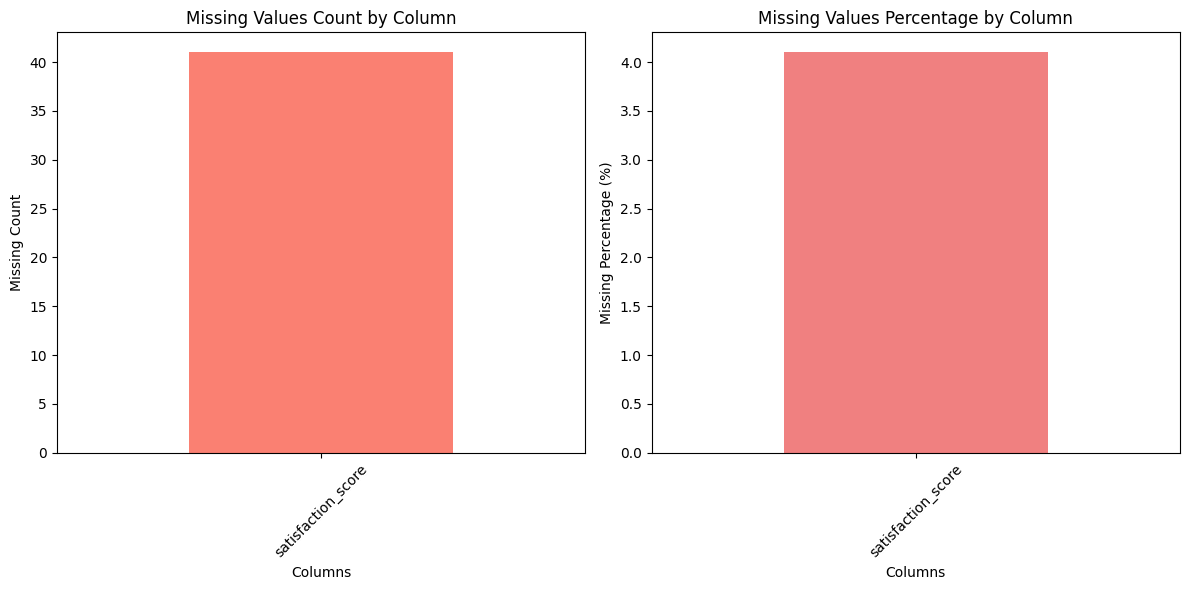

In [5]:
# 1. Missing Values Analysis
print("=" * 60)
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 60)

# Calculate missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Create missing values summary
missing_summary = pd.DataFrame({
    'Column': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percentage': missing_percentage.values
}).sort_values('Missing Count', ascending=False)

# Filter to show only columns with missing values
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

if len(missing_summary) > 0:
    print("⚠️  Columns with missing values:")
    display(missing_summary)
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    missing_data[missing_data > 0].plot(kind='bar', color='salmon')
    plt.title('Missing Values Count by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    missing_percentage[missing_percentage > 0].plot(kind='bar', color='lightcoral')
    plt.title('Missing Values Percentage by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in the dataset!")
    print("🎉 Data completeness: 100%")


In [6]:
# 2. Duplicate Records Analysis
print("\n" + "=" * 60)
print("🔄 DUPLICATE RECORDS ANALYSIS")
print("=" * 60)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

if duplicate_rows > 0:
    print(f"Percentage of duplicate rows: {(duplicate_rows / len(df)) * 100:.2f}%")
    print("\nSample duplicate rows:")
    display(df[df.duplicated(keep=False)].head())
else:
    print("✅ No duplicate rows found!")

# Check for duplicate customer IDs (should be unique)
duplicate_customer_ids = df['customer_id'].duplicated().sum()
print(f"\nDuplicate customer IDs: {duplicate_customer_ids}")
if duplicate_customer_ids == 0:
    print("✅ All customer IDs are unique!")
else:
    print("⚠️  Found duplicate customer IDs - this needs investigation!")



🔄 DUPLICATE RECORDS ANALYSIS
Total duplicate rows: 0
✅ No duplicate rows found!

Duplicate customer IDs: 0
✅ All customer IDs are unique!


In [7]:
# 3. Data Type Validation
print("\n" + "=" * 60)
print("📊 DATA TYPE VALIDATION")
print("=" * 60)

# Check data types and suggest corrections
print("Current data types:")
data_types = pd.DataFrame({
    'Column': df.dtypes.index,
    'Current Type': df.dtypes.values,
    'Sample Values': [str(list(df[col].dropna().head(3))) for col in df.columns]
})
display(data_types)

# Check for potential data type issues
print("\n🔍 Data Type Issues Check:")

# Check numeric columns for non-numeric values
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].dtype == 'object':
        print(f"⚠️  {col}: Should be numeric but is object type")

# Check for negative values where they shouldn't exist
print("\n📈 Value Range Validation:")
numeric_columns = ['age', 'total_purchases', 'total_spent', 'avg_session_duration', 
                   'page_views_per_session', 'bounce_rate', 'satisfaction_score', 'support_tickets']

for col in numeric_columns:
    if col in df.columns:
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"{col}: Range [{min_val:.2f}, {max_val:.2f}]")
        
        # Check for logical issues
        if col == 'age' and (min_val < 0 or max_val > 120):
            print(f"  ⚠️  {col}: Unusual age values detected!")
        elif col == 'bounce_rate' and (min_val < 0 or max_val > 1):
            print(f"  ⚠️  {col}: Bounce rate should be between 0 and 1!")
        elif col == 'satisfaction_score' and (min_val < 1 or max_val > 10):
            print(f"  ⚠️  {col}: Satisfaction score should be between 1 and 10!")
        elif col in ['total_purchases', 'page_views_per_session', 'support_tickets'] and min_val < 0:
            print(f"  ⚠️  {col}: Negative values detected!")



📊 DATA TYPE VALIDATION
Current data types:


,Column,Current Type,Sample Values
0,customer_id,object,"['CUST_0001', 'CUST_0002', 'CUST_0003']"
1,age,int64,"[52, 42, 54]"
2,gender,object,"['M', 'M', 'F']"
3,city,object,"['Lucerne', 'Basel', 'Bern']"
4,registration_date,datetime64[ns],"[Timestamp('2023-11-24 00:00:00'), Timestamp('..."
5,total_purchases,int64,"[7, 5, 6]"
6,total_spent,float64,"[334.1779699233904, 245.00853602340035, 303.35..."
7,avg_session_duration,float64,"[5.893653862437931, 7.441323274213411, 23.6061..."
8,page_views_per_session,int64,"[6, 19, 13]"
9,bounce_rate,float64,"[0.24322767282890906, 0.2328241491510232, 0.15..."



🔍 Data Type Issues Check:

📈 Value Range Validation:
age: Range [18.00, 80.00]
total_purchases: Range [1.00, 16.00]
total_spent: Range [42.72, 700.88]
avg_session_duration: Range [5.00, 35.00]
page_views_per_session: Range [2.00, 25.00]
bounce_rate: Range [0.01, 0.73]
satisfaction_score: Range [1.03, 10.00]
support_tickets: Range [0.00, 6.00]



🎯 OUTLIER DETECTION


,Column,Outlier Count,Outlier Percentage,Lower Bound,Upper Bound,Min Value,Max Value
0,age,0,0.00%,6.50,82.50,18.00,80.00
1,total_purchases,24,2.40%,0.50,12.50,1.00,16.00
2,total_spent,6,0.60%,37.73,628.75,42.72,700.88
3,avg_session_duration,47,4.70%,-7.99,34.20,5.00,35.00
4,page_views_per_session,14,1.40%,3.00,19.00,2.00,25.00
5,bounce_rate,3,0.30%,-0.15,0.63,0.01,0.73
6,satisfaction_score,7,0.70%,1.26,9.23,1.03,10.00
7,support_tickets,1,0.10%,-3.00,5.00,0.00,6.00


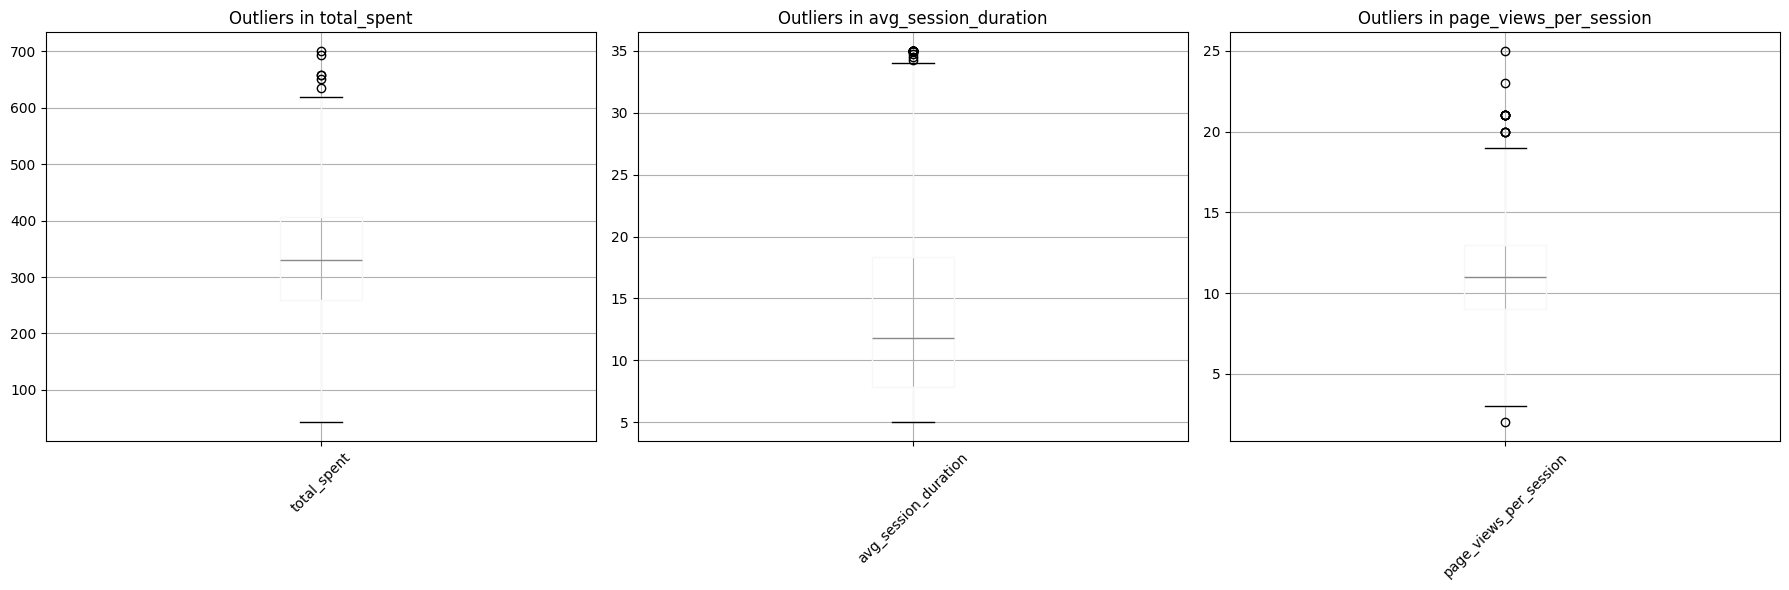

In [8]:
# 4. Outlier Detection
print("\n" + "=" * 60)
print("🎯 OUTLIER DETECTION")
print("=" * 60)

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in numeric columns
numeric_columns = ['age', 'total_purchases', 'total_spent', 'avg_session_duration', 
                   'page_views_per_session', 'bounce_rate', 'satisfaction_score', 'support_tickets']

outlier_summary = []

for col in numeric_columns:
    if col in df.columns:
        outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        outlier_summary.append({
            'Column': col,
            'Outlier Count': outlier_count,
            'Outlier Percentage': f"{outlier_percentage:.2f}%",
            'Lower Bound': f"{lower_bound:.2f}",
            'Upper Bound': f"{upper_bound:.2f}",
            'Min Value': f"{df[col].min():.2f}",
            'Max Value': f"{df[col].max():.2f}"
        })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

# Visualize outliers for key columns
key_columns = ['total_spent', 'avg_session_duration', 'page_views_per_session']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(key_columns):
    if col in df.columns:
        # Box plot
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Outliers in {col}')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# 5. Data Consistency Checks
print("\n" + "=" * 60)
print("✅ DATA CONSISTENCY CHECKS")
print("=" * 60)

# Check date consistency
print("📅 Date Consistency:")
print(f"Registration date range: {df['registration_date'].min()} to {df['registration_date'].max()}")
print(f"Last activity range: {df['last_activity'].min()} to {df['last_activity'].max()}")

# Check if last activity is after registration (logical consistency)
date_issues = df[df['last_activity'] < df['registration_date']]
print(f"Customers with last activity before registration: {len(date_issues)}")

if len(date_issues) > 0:
    print("⚠️  Found date inconsistencies!")
    display(date_issues[['customer_id', 'registration_date', 'last_activity']].head())
else:
    print("✅ All dates are logically consistent!")

# Check categorical value consistency
print("\n🏷️  Categorical Value Consistency:")
categorical_columns = ['gender', 'subscription_type', 'device_type', 'referral_source']

for col in categorical_columns:
    if col in df.columns:
        unique_values = df[col].unique()
        print(f"{col}: {len(unique_values)} unique values - {list(unique_values)}")
        
        # Check for potential typos or inconsistencies
        if col == 'gender':
            expected_values = ['M', 'F', 'Other', 'Male', 'Female']
            unexpected = [val for val in unique_values if val not in expected_values]
            if unexpected:
                print(f"  ⚠️  Unexpected gender values: {unexpected}")

# Check business logic consistency
print("\n💼 Business Logic Consistency:")

# Check if customers with high spending have high satisfaction
high_spenders = df[df['total_spent'] > df['total_spent'].quantile(0.9)]
high_spender_satisfaction = high_spenders['satisfaction_score'].mean()
overall_satisfaction = df['satisfaction_score'].mean()

print(f"High spender satisfaction (top 10%): {high_spender_satisfaction:.2f}")
print(f"Overall satisfaction: {overall_satisfaction:.2f}")

# Check bounce rate vs session duration relationship
print(f"\nBounce rate vs Session duration correlation: {df['bounce_rate'].corr(df['avg_session_duration']):.3f}")
print("(Expected: Negative correlation - higher bounce rate should mean shorter sessions)")



✅ DATA CONSISTENCY CHECKS
📅 Date Consistency:
Registration date range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Last activity range: 2023-01-06 00:00:00 to 2023-12-31 00:00:00
Customers with last activity before registration: 0
✅ All dates are logically consistent!

🏷️  Categorical Value Consistency:
gender: 3 unique values - ['M', 'F', 'Other']
subscription_type: 3 unique values - [np.str_('Premium'), 'Basic', np.str_('Enterprise')]
device_type: 3 unique values - ['Mobile', 'Desktop', 'Tablet']
referral_source: 5 unique values - ['Email', 'Social Media', 'Organic', 'Paid Ads', 'Referral']

💼 Business Logic Consistency:
High spender satisfaction (top 10%): 5.42
Overall satisfaction: 5.26

Bounce rate vs Session duration correlation: -0.126
(Expected: Negative correlation - higher bounce rate should mean shorter sessions)


In [10]:
# 6. Data Quality Summary Report
print("\n" + "=" * 60)
print("📋 DATA QUALITY SUMMARY REPORT")
print("=" * 60)

# Calculate overall data quality score
total_issues = 0
max_possible_issues = 10

# Missing values score
missing_score = 1 - (df.isnull().sum().sum() / (len(df) * len(df.columns)))
total_issues += (1 - missing_score) * 3

# Duplicate score
duplicate_score = 1 - (df.duplicated().sum() / len(df))
total_issues += (1 - duplicate_score) * 2

# Data type consistency score
type_issues = 0
for col in df.select_dtypes(include=['object']).columns:
    if col in ['age', 'total_purchases', 'total_spent']:  # Should be numeric
        type_issues += 1
type_score = 1 - (type_issues / len(df.columns))
total_issues += (1 - type_score) * 2

# Outlier score (based on reasonable outlier percentage)
outlier_issues = 0
for col in ['total_spent', 'avg_session_duration', 'page_views_per_session']:
    if col in df.columns:
        outliers, _, _ = detect_outliers_iqr(df, col)
        outlier_pct = len(outliers) / len(df)
        if outlier_pct > 0.1:  # More than 10% outliers
            outlier_issues += 1
outlier_score = 1 - (outlier_issues / 3)
total_issues += (1 - outlier_score) * 2

# Consistency score
consistency_issues = 0
if len(df[df['last_activity'] < df['registration_date']]) > 0:
    consistency_issues += 1
consistency_score = 1 - (consistency_issues / 1)
total_issues += (1 - consistency_score) * 1

# Calculate final quality score
quality_score = max(0, 1 - (total_issues / max_possible_issues))

print(f"🎯 Overall Data Quality Score: {quality_score:.2%}")
print()

# Quality assessment
if quality_score >= 0.9:
    quality_rating = "🟢 EXCELLENT"
elif quality_score >= 0.8:
    quality_rating = "🟡 GOOD"
elif quality_score >= 0.7:
    quality_rating = "🟠 FAIR"
else:
    quality_rating = "🔴 POOR"

print(f"Quality Rating: {quality_rating}")
print()

# Recommendations
print("📝 RECOMMENDATIONS:")
if missing_score < 1:
    print("• Address missing values through imputation or data collection")
if duplicate_score < 1:
    print("• Remove or investigate duplicate records")
if type_score < 1:
    print("• Correct data types for better analysis")
if outlier_score < 1:
    print("• Investigate and handle outliers appropriately")
if consistency_score < 1:
    print("• Fix data consistency issues")

print(f"\n✅ Data is ready for analysis with {quality_score:.1%} quality score!")



📋 DATA QUALITY SUMMARY REPORT
🎯 Overall Data Quality Score: 99.92%

Quality Rating: 🟢 EXCELLENT

📝 RECOMMENDATIONS:
• Address missing values through imputation or data collection

✅ Data is ready for analysis with 99.9% quality score!


## Exploratory Visualizations

Create comprehensive visualizations to understand data distributions, relationships, and patterns in customer behavior.


📊 DISTRIBUTION ANALYSIS - NUMERIC VARIABLES


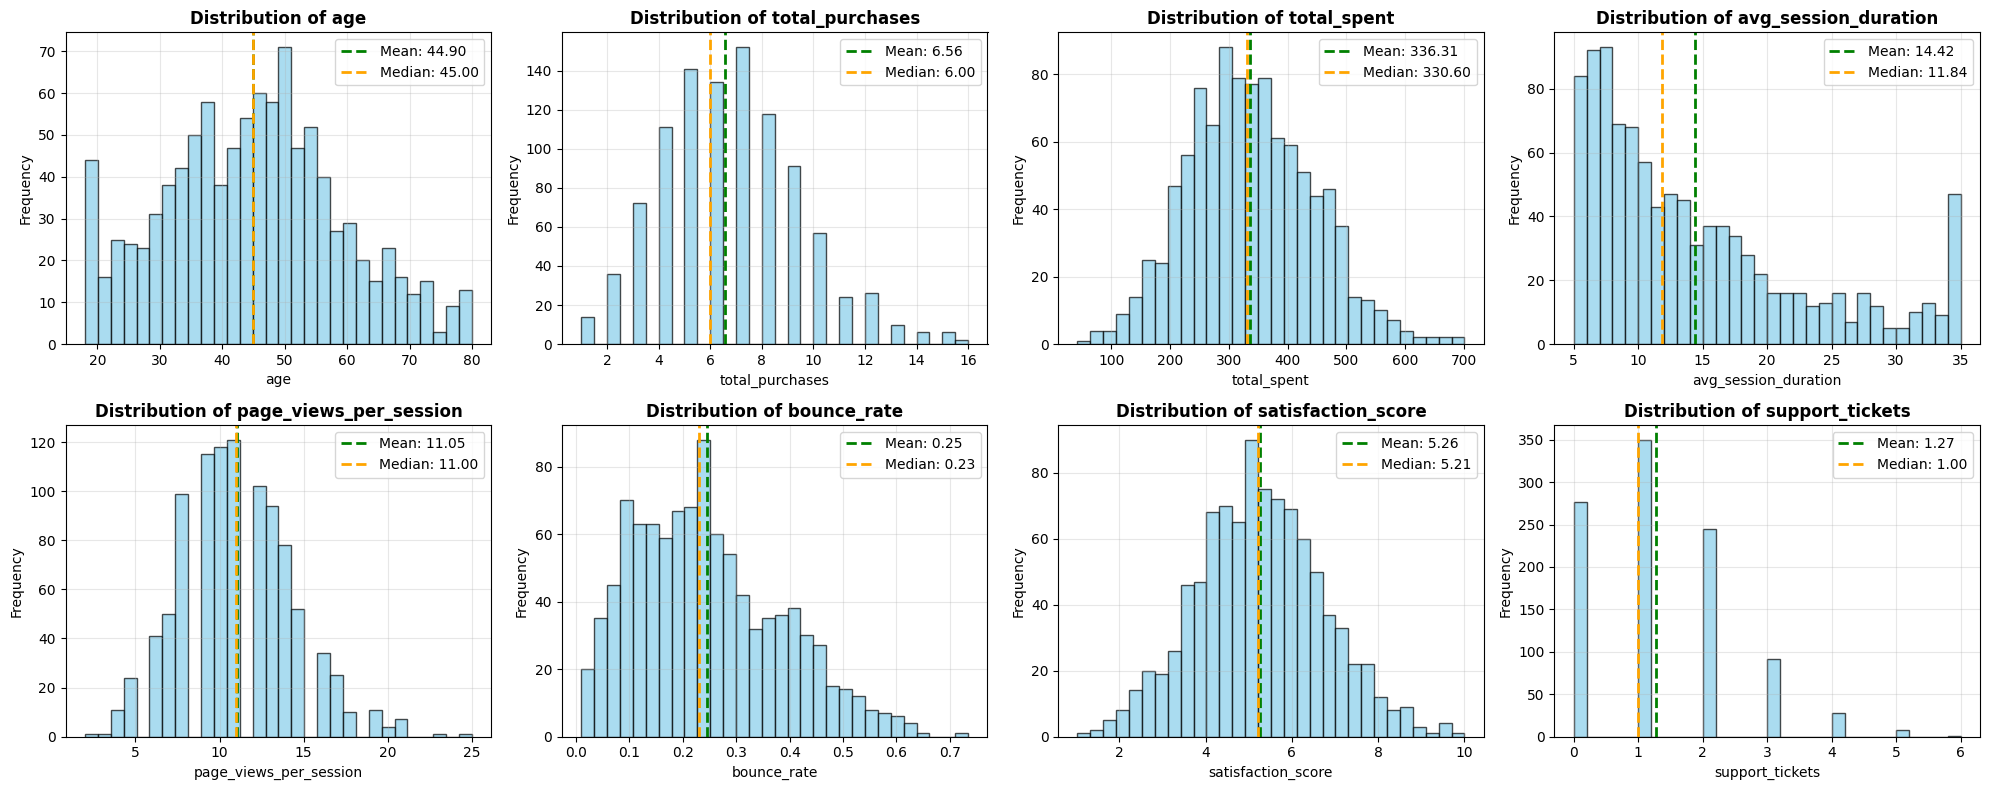


📈 DISTRIBUTION SUMMARY STATISTICS:
--------------------------------------------------


,age,total_purchases,total_spent,avg_session_duration,page_views_per_session,bounce_rate,satisfaction_score,support_tickets
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,959.000000,1000.000000
mean,44.904000,6.564000,336.309322,14.423653,11.054000,0.245934,5.256682,1.274000
std,14.178639,2.701704,106.443290,8.367707,3.342193,0.136246,1.472803,1.104601
min,18.000000,1.000000,42.722190,5.002407,2.000000,0.010000,1.027371,0.000000
25%,35.000000,5.000000,259.362431,7.830427,9.000000,0.139140,4.246442,0.000000
50%,45.000000,6.000000,330.603690,11.840674,11.000000,0.231347,5.213568,1.000000
75%,54.000000,8.000000,407.118878,18.380054,13.000000,0.335165,6.239019,2.000000
max,80.000000,16.000000,700.884892,35.000000,25.000000,0.734305,10.000000,6.000000


In [11]:
# 1. Distribution Analysis - Numeric Variables
print("=" * 60)
print("📊 DISTRIBUTION ANALYSIS - NUMERIC VARIABLES")
print("=" * 60)

# Select key numeric variables for distribution analysis
numeric_vars = ['age', 'total_purchases', 'total_spent', 'avg_session_duration', 
                'page_views_per_session', 'bounce_rate', 'satisfaction_score', 'support_tickets']

# Filter to only include columns that exist in the dataframe
numeric_vars = [var for var in numeric_vars if var in df.columns]

# Create distribution plots
n_vars = len(numeric_vars)
n_cols = min(4, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.ravel()

for i, var in enumerate(numeric_vars):
    if i < len(axes):
        # Histogram
        df[var].hist(bins=30, alpha=0.7, ax=axes[i], color='skyblue', edgecolor='black')
        
        # Add statistics
        mean_val = df[var].mean()
        median_val = df[var].median()
        axes[i].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        
        axes[i].set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_vars, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics for distributions
print("\n📈 DISTRIBUTION SUMMARY STATISTICS:")
print("-" * 50)
distribution_stats = df[numeric_vars].describe()
display(distribution_stats)



🏷️  CATEGORICAL VARIABLES ANALYSIS


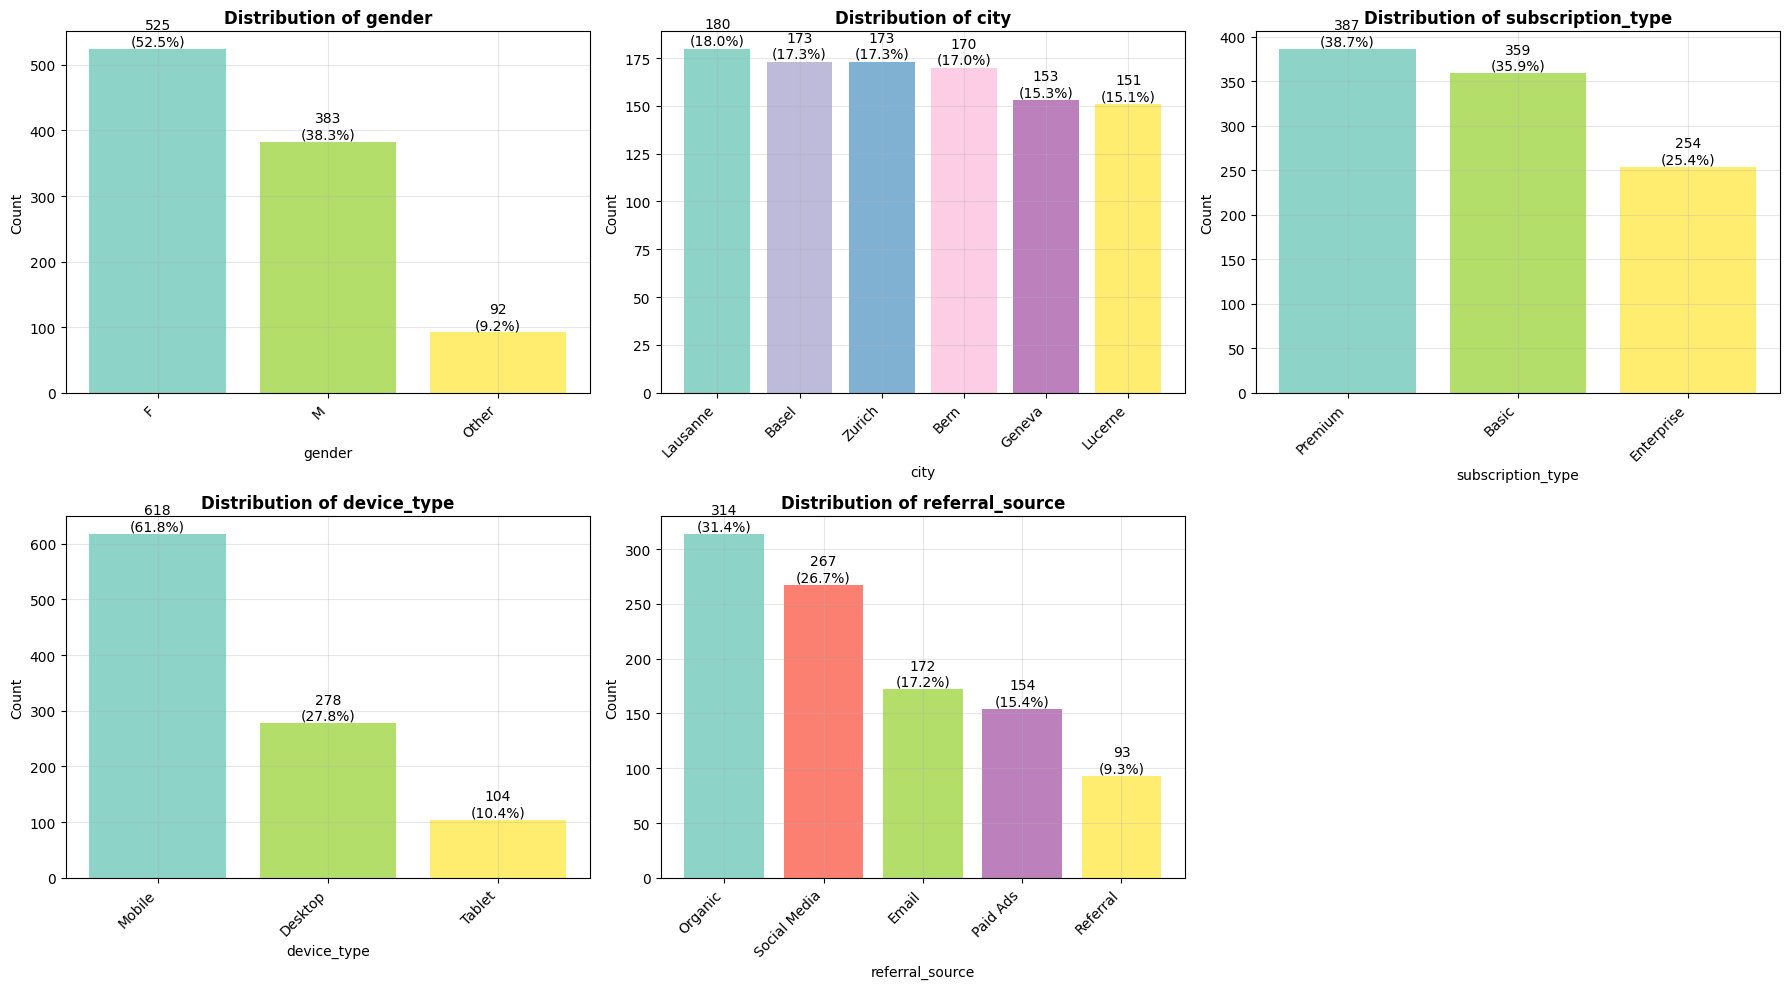


📊 CATEGORICAL VARIABLES SUMMARY:
--------------------------------------------------

gender:
  F: 525 (52.5%)
  M: 383 (38.3%)
  Other: 92 (9.2%)

city:
  Lausanne: 180 (18.0%)
  Basel: 173 (17.3%)
  Zurich: 173 (17.3%)
  Bern: 170 (17.0%)
  Geneva: 153 (15.3%)
  Lucerne: 151 (15.1%)

subscription_type:
  Premium: 387 (38.7%)
  Basic: 359 (35.9%)
  Enterprise: 254 (25.4%)

device_type:
  Mobile: 618 (61.8%)
  Desktop: 278 (27.8%)
  Tablet: 104 (10.4%)

referral_source:
  Organic: 314 (31.4%)
  Social Media: 267 (26.7%)
  Email: 172 (17.2%)
  Paid Ads: 154 (15.4%)
  Referral: 93 (9.3%)


In [12]:
# 2. Categorical Variables Analysis
print("\n" + "=" * 60)
print("🏷️  CATEGORICAL VARIABLES ANALYSIS")
print("=" * 60)

# Select categorical variables
categorical_vars = ['gender', 'city', 'subscription_type', 'device_type', 'referral_source']

# Filter to only include columns that exist in the dataframe
categorical_vars = [var for var in categorical_vars if var in df.columns]

# Create count plots for categorical variables
n_vars = len(categorical_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
if n_vars == 1:
    axes = [axes]
elif n_rows == 1 and n_cols > 1:
    axes = axes.reshape(1, -1)
elif n_rows > 1 and n_cols == 1:
    axes = axes.reshape(-1, 1)
axes = axes.ravel()

for i, var in enumerate(categorical_vars):
    if i < len(axes):
        # Count plot
        value_counts = df[var].value_counts()
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=plt.cm.Set3(np.linspace(0, 1, len(value_counts))))
        
        # Add value labels on bars
        for j, (bar, count) in enumerate(zip(bars, value_counts.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{count}\n({count/len(df)*100:.1f}%)',
                        ha='center', va='bottom', fontsize=10)
        
        axes[i].set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_vars, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Display categorical statistics
print("\n📊 CATEGORICAL VARIABLES SUMMARY:")
print("-" * 50)
for var in categorical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        value_counts = df[var].value_counts()
        for value, count in value_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {value}: {count} ({percentage:.1f}%)")



🔗 CORRELATION ANALYSIS


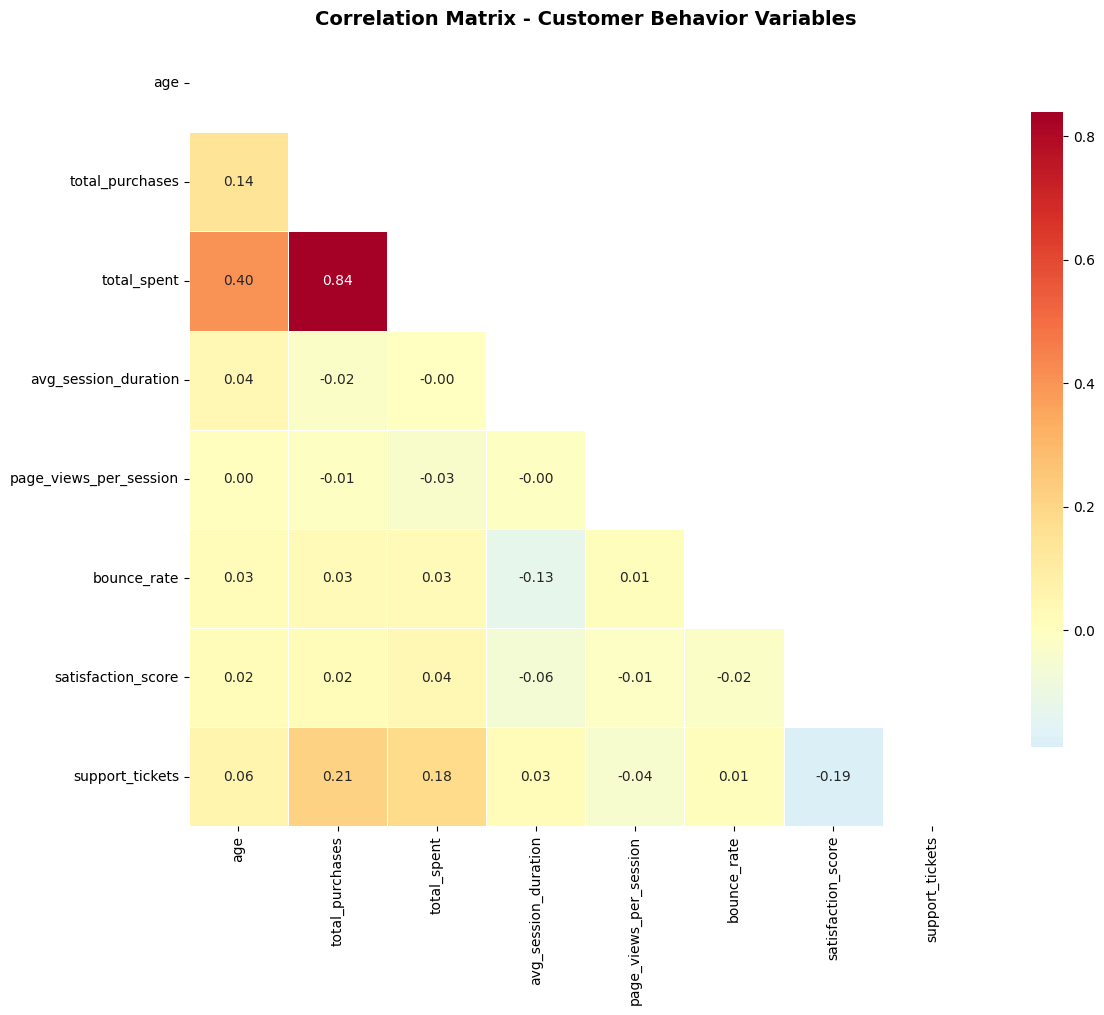


🔍 STRONGEST CORRELATIONS:
----------------------------------------
total_purchases ↔ total_spent: 0.839
age ↔ total_spent: 0.403
total_purchases ↔ support_tickets: 0.212
satisfaction_score ↔ support_tickets: -0.189
total_spent ↔ support_tickets: 0.184


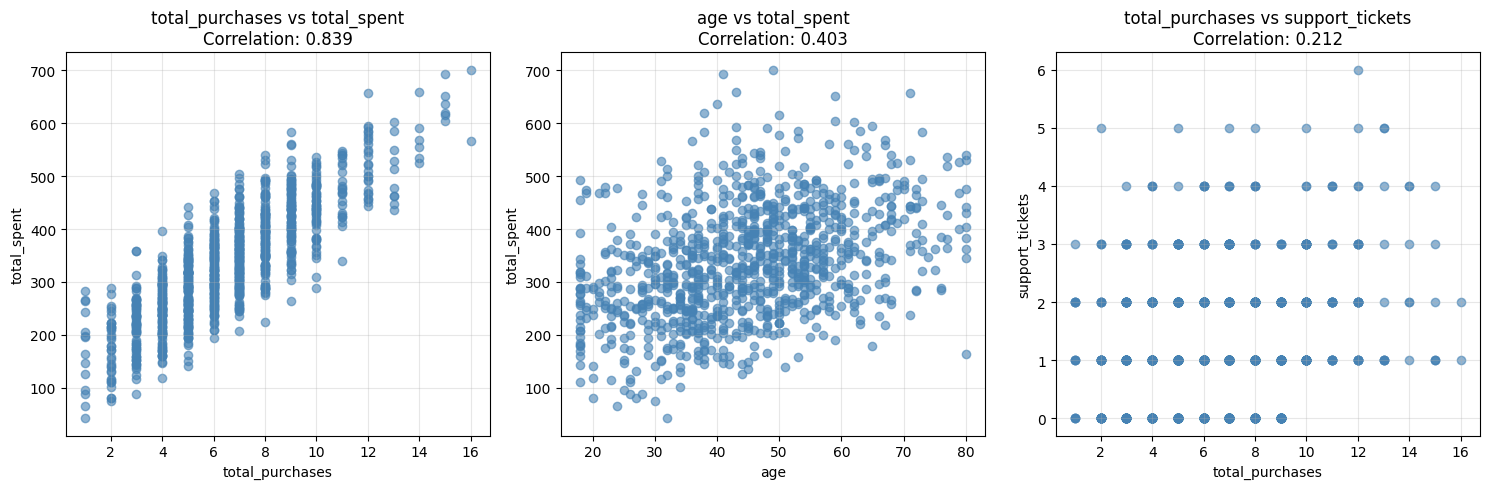

In [13]:
# 3. Correlation Analysis
print("\n" + "=" * 60)
print("🔗 CORRELATION ANALYSIS")
print("=" * 60)

# Calculate correlation matrix for numeric variables
correlation_vars = ['age', 'total_purchases', 'total_spent', 'avg_session_duration', 
                   'page_views_per_session', 'bounce_rate', 'satisfaction_score', 'support_tickets']

# Filter to only include columns that exist in the dataframe
correlation_vars = [var for var in correlation_vars if var in df.columns]

if len(correlation_vars) > 1:
    corr_matrix = df[correlation_vars].corr()
else:
    print("⚠️  Not enough numeric variables for correlation analysis")
    corr_matrix = pd.DataFrame()

# Create correlation heatmap
if not corr_matrix.empty:
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
    plt.title('Correlation Matrix - Customer Behavior Variables', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Find strongest correlations
    print("\n🔍 STRONGEST CORRELATIONS:")
    print("-" * 40)

    # Get upper triangle of correlation matrix
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

    corr_df = pd.DataFrame(corr_pairs)
    corr_df['Abs_Correlation'] = abs(corr_df['Correlation'])
    strongest_corr = corr_df.nlargest(5, 'Abs_Correlation')

    for _, row in strongest_corr.iterrows():
        print(f"{row['Variable 1']} ↔ {row['Variable 2']}: {row['Correlation']:.3f}")

    # Create scatter plots for strongest correlations
    if len(strongest_corr) > 0:
        n_plots = min(3, len(strongest_corr))
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        for i, (_, row) in enumerate(strongest_corr.head(n_plots).iterrows()):
            var1, var2 = row['Variable 1'], row['Variable 2']
            axes[i].scatter(df[var1], df[var2], alpha=0.6, color='steelblue')
            axes[i].set_xlabel(var1)
            axes[i].set_ylabel(var2)
            axes[i].set_title(f'{var1} vs {var2}\nCorrelation: {row["Correlation"]:.3f}')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️  Cannot create correlation analysis - insufficient numeric variables")



👥 CUSTOMER SEGMENTATION ANALYSIS


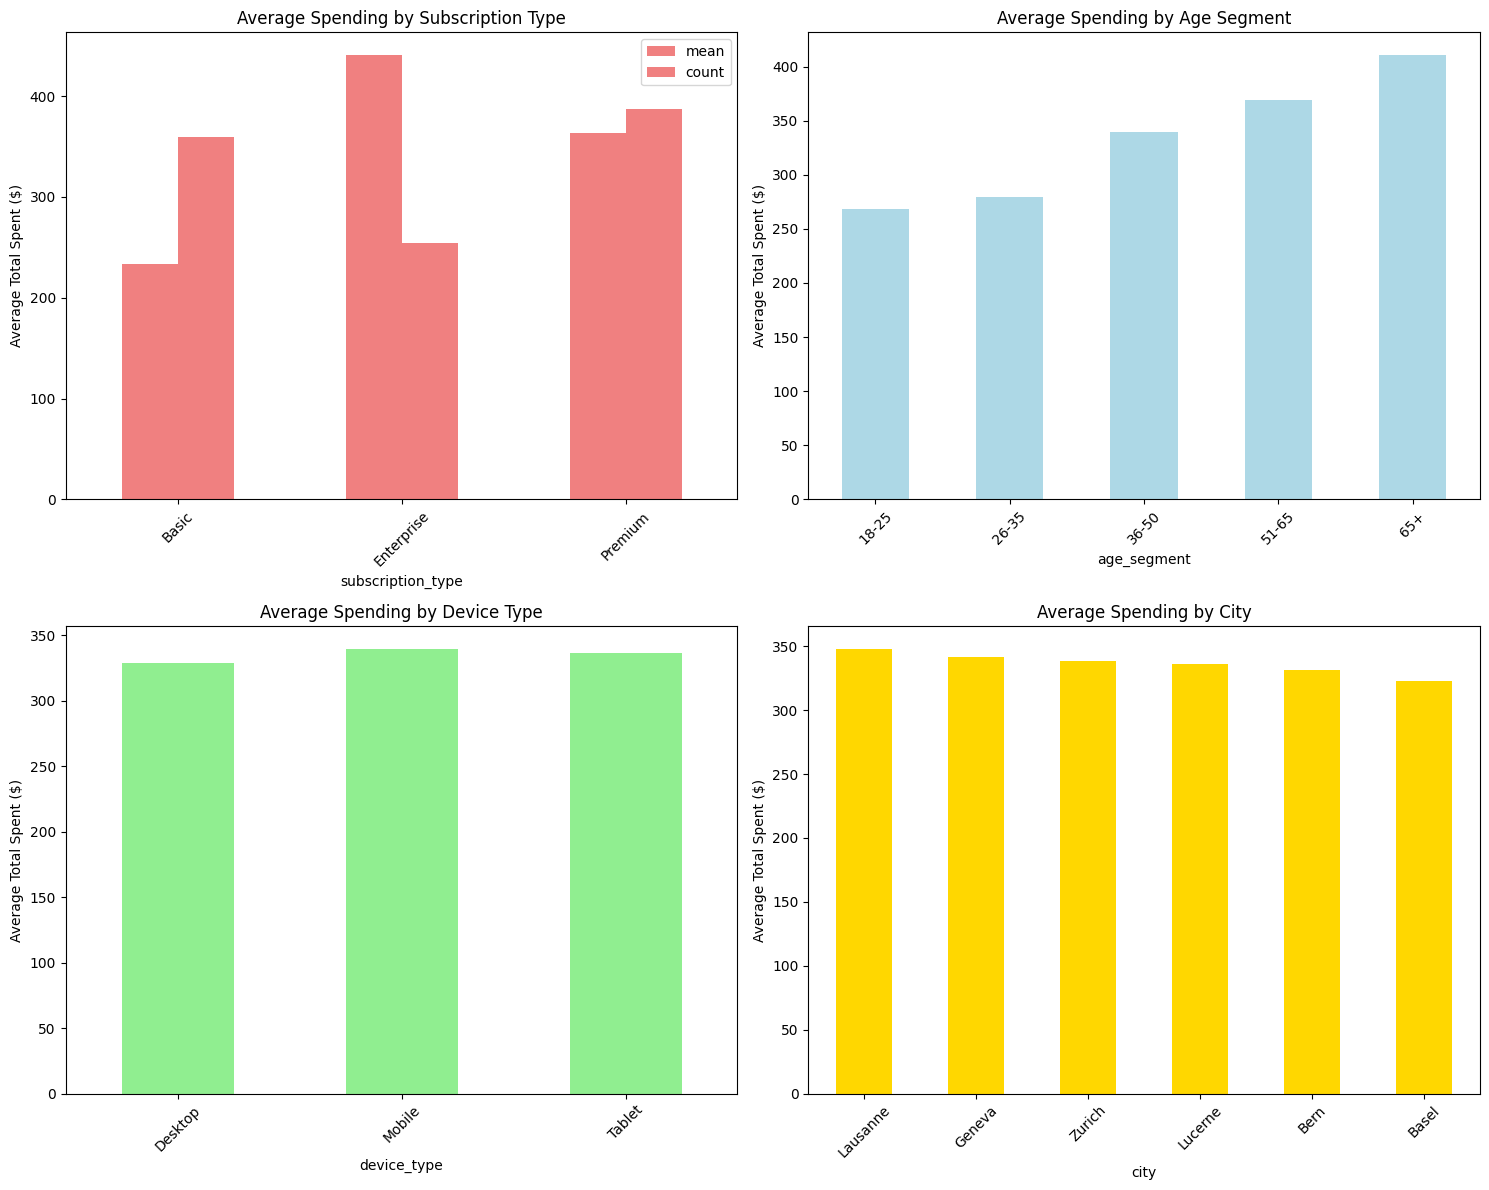


📊 CUSTOMER SEGMENTATION SUMMARY:
--------------------------------------------------
Spending Segments:
  Medium: 855 customers (85.5%) - Avg: $338.45
  Low: 84 customers (8.4%) - Avg: $153.79
  High: 61 customers (6.1%) - Avg: $557.71
  VIP: 0 customers (0.0%) - Avg: $nan

Age Segments:
  36-50: 399 customers (39.9%)
  51-65: 246 customers (24.6%)
  26-35: 169 customers (16.9%)
  18-25: 95 customers (9.5%)
  65+: 91 customers (9.1%)


In [14]:
# 4. Customer Segmentation Analysis
print("\n" + "=" * 60)
print("👥 CUSTOMER SEGMENTATION ANALYSIS")
print("=" * 60)

# Create customer segments based on spending behavior
try:
    df['spending_segment'] = pd.cut(df['total_spent'], 
                                   bins=[0, 200, 500, 1000, float('inf')], 
                                   labels=['Low', 'Medium', 'High', 'VIP'])
except Exception as e:
    print(f"Warning: Could not create spending segments: {e}")
    df['spending_segment'] = 'Unknown'

# Create age segments
try:
    df['age_segment'] = pd.cut(df['age'], 
                              bins=[0, 25, 35, 50, 65, 100], 
                              labels=['18-25', '26-35', '36-50', '51-65', '65+'])
except Exception as e:
    print(f"Warning: Could not create age segments: {e}")
    df['age_segment'] = 'Unknown'

# Analyze spending by segments
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Spending by subscription type
spending_by_subscription = df.groupby('subscription_type')['total_spent'].agg(['mean', 'count'])
spending_by_subscription.plot(kind='bar', ax=axes[0,0], color='lightcoral')
axes[0,0].set_title('Average Spending by Subscription Type')
axes[0,0].set_ylabel('Average Total Spent ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Spending by age segment
spending_by_age = df.groupby('age_segment')['total_spent'].mean()
spending_by_age.plot(kind='bar', ax=axes[0,1], color='lightblue')
axes[0,1].set_title('Average Spending by Age Segment')
axes[0,1].set_ylabel('Average Total Spent ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Spending by device type
spending_by_device = df.groupby('device_type')['total_spent'].mean()
spending_by_device.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Average Spending by Device Type')
axes[1,0].set_ylabel('Average Total Spent ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Spending by city
spending_by_city = df.groupby('city')['total_spent'].mean().sort_values(ascending=False)
spending_by_city.plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Average Spending by City')
axes[1,1].set_ylabel('Average Total Spent ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display segmentation summary
print("\n📊 CUSTOMER SEGMENTATION SUMMARY:")
print("-" * 50)
print("Spending Segments:")
spending_segment_summary = df['spending_segment'].value_counts()
for segment, count in spending_segment_summary.items():
    percentage = (count / len(df)) * 100
    avg_spending = df[df['spending_segment'] == segment]['total_spent'].mean()
    print(f"  {segment}: {count} customers ({percentage:.1f}%) - Avg: ${avg_spending:.2f}")

print("\nAge Segments:")
age_segment_summary = df['age_segment'].value_counts()
for segment, count in age_segment_summary.items():
    percentage = (count / len(df)) * 100
    print(f"  {segment}: {count} customers ({percentage:.1f}%)")



🎨 INTERACTIVE VISUALIZATIONS
📊 Using 959 customers with complete satisfaction data
Creating scatter plot...
❌ Error creating interactive visualizations: Mime type rendering requires nbformat>=4.2.0 but it is not installed
🔄 Creating fallback static visualizations...


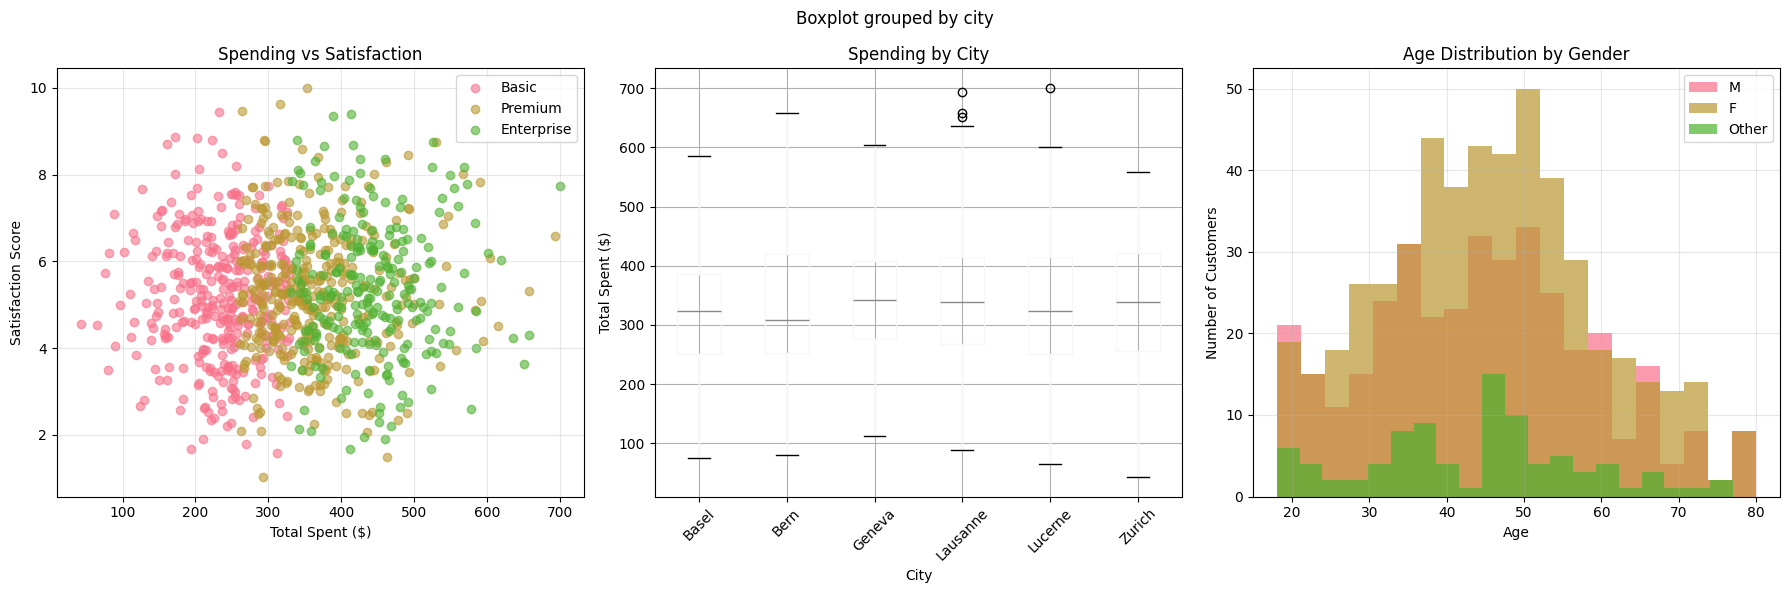

✅ Fallback static visualizations created successfully!


In [15]:
# 5. Interactive Visualizations with Plotly
print("\n" + "=" * 60)
print("🎨 INTERACTIVE VISUALIZATIONS")
print("=" * 60)

try:
    # Prepare clean data for interactive visualizations
    df_clean = df.dropna(subset=['satisfaction_score']).copy()
    
    # Ensure proper data types for Plotly
    df_clean['subscription_type'] = df_clean['subscription_type'].astype(str)
    df_clean['city'] = df_clean['city'].astype(str)
    df_clean['gender'] = df_clean['gender'].astype(str)
    df_clean['device_type'] = df_clean['device_type'].astype(str)
    
    print(f"📊 Using {len(df_clean)} customers with complete satisfaction data")
    
    # Create interactive scatter plot: Total Spent vs Satisfaction Score
    print("Creating scatter plot...")
    fig_scatter = px.scatter(
        df_clean, 
        x='total_spent', 
        y='satisfaction_score', 
        color='subscription_type', 
        size='total_purchases',
        hover_data=['age', 'city', 'device_type'],
        title='Customer Spending vs Satisfaction by Subscription Type',
        labels={
            'total_spent': 'Total Spent ($)', 
            'satisfaction_score': 'Satisfaction Score',
            'subscription_type': 'Subscription Type',
            'total_purchases': 'Total Purchases'
        }
    )
    
    fig_scatter.update_layout(
        width=800, 
        height=600,
        showlegend=True,
        title_x=0.5
    )
    fig_scatter.show()
    
    # Create interactive box plot for spending by city
    print("Creating box plot...")
    fig_box = px.box(
        df_clean, 
        x='city', 
        y='total_spent', 
        color='subscription_type',
        title='Spending Distribution by City and Subscription Type',
        labels={
            'total_spent': 'Total Spent ($)', 
            'city': 'City',
            'subscription_type': 'Subscription Type'
        }
    )
    
    fig_box.update_layout(
        width=1000, 
        height=600,
        xaxis_tickangle=-45,
        title_x=0.5
    )
    fig_box.show()
    
    # Create interactive histogram for age distribution
    print("Creating histogram...")
    fig_hist = px.histogram(
        df_clean, 
        x='age', 
        color='gender', 
        nbins=20,
        title='Age Distribution by Gender',
        labels={
            'age': 'Age', 
            'count': 'Number of Customers',
            'gender': 'Gender'
        }
    )
    
    fig_hist.update_layout(
        width=800, 
        height=500,
        showlegend=True,
        title_x=0.5
    )
    fig_hist.show()
    
    print("✅ Interactive visualizations created successfully!")
    print("💡 Hover over the charts to see detailed information!")
    print("🔍 Use the legend to filter by different categories!")
    
except Exception as e:
    print(f"❌ Error creating interactive visualizations: {e}")
    print("🔄 Creating fallback static visualizations...")
    
    # Fallback: Create static versions
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Scatter plot
    for sub_type in df_clean['subscription_type'].unique():
        mask = df_clean['subscription_type'] == sub_type
        axes[0].scatter(df_clean[mask]['total_spent'], df_clean[mask]['satisfaction_score'], 
                       label=sub_type, alpha=0.6)
    axes[0].set_xlabel('Total Spent ($)')
    axes[0].set_ylabel('Satisfaction Score')
    axes[0].set_title('Spending vs Satisfaction')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    df_clean.boxplot(column='total_spent', by='city', ax=axes[1])
    axes[1].set_title('Spending by City')
    axes[1].set_xlabel('City')
    axes[1].set_ylabel('Total Spent ($)')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Histogram
    for gender in df_clean['gender'].unique():
        mask = df_clean['gender'] == gender
        axes[2].hist(df_clean[mask]['age'], alpha=0.7, label=gender, bins=20)
    axes[2].set_xlabel('Age')
    axes[2].set_ylabel('Number of Customers')
    axes[2].set_title('Age Distribution by Gender')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("✅ Fallback static visualizations created successfully!")



📅 TIME-BASED ANALYSIS


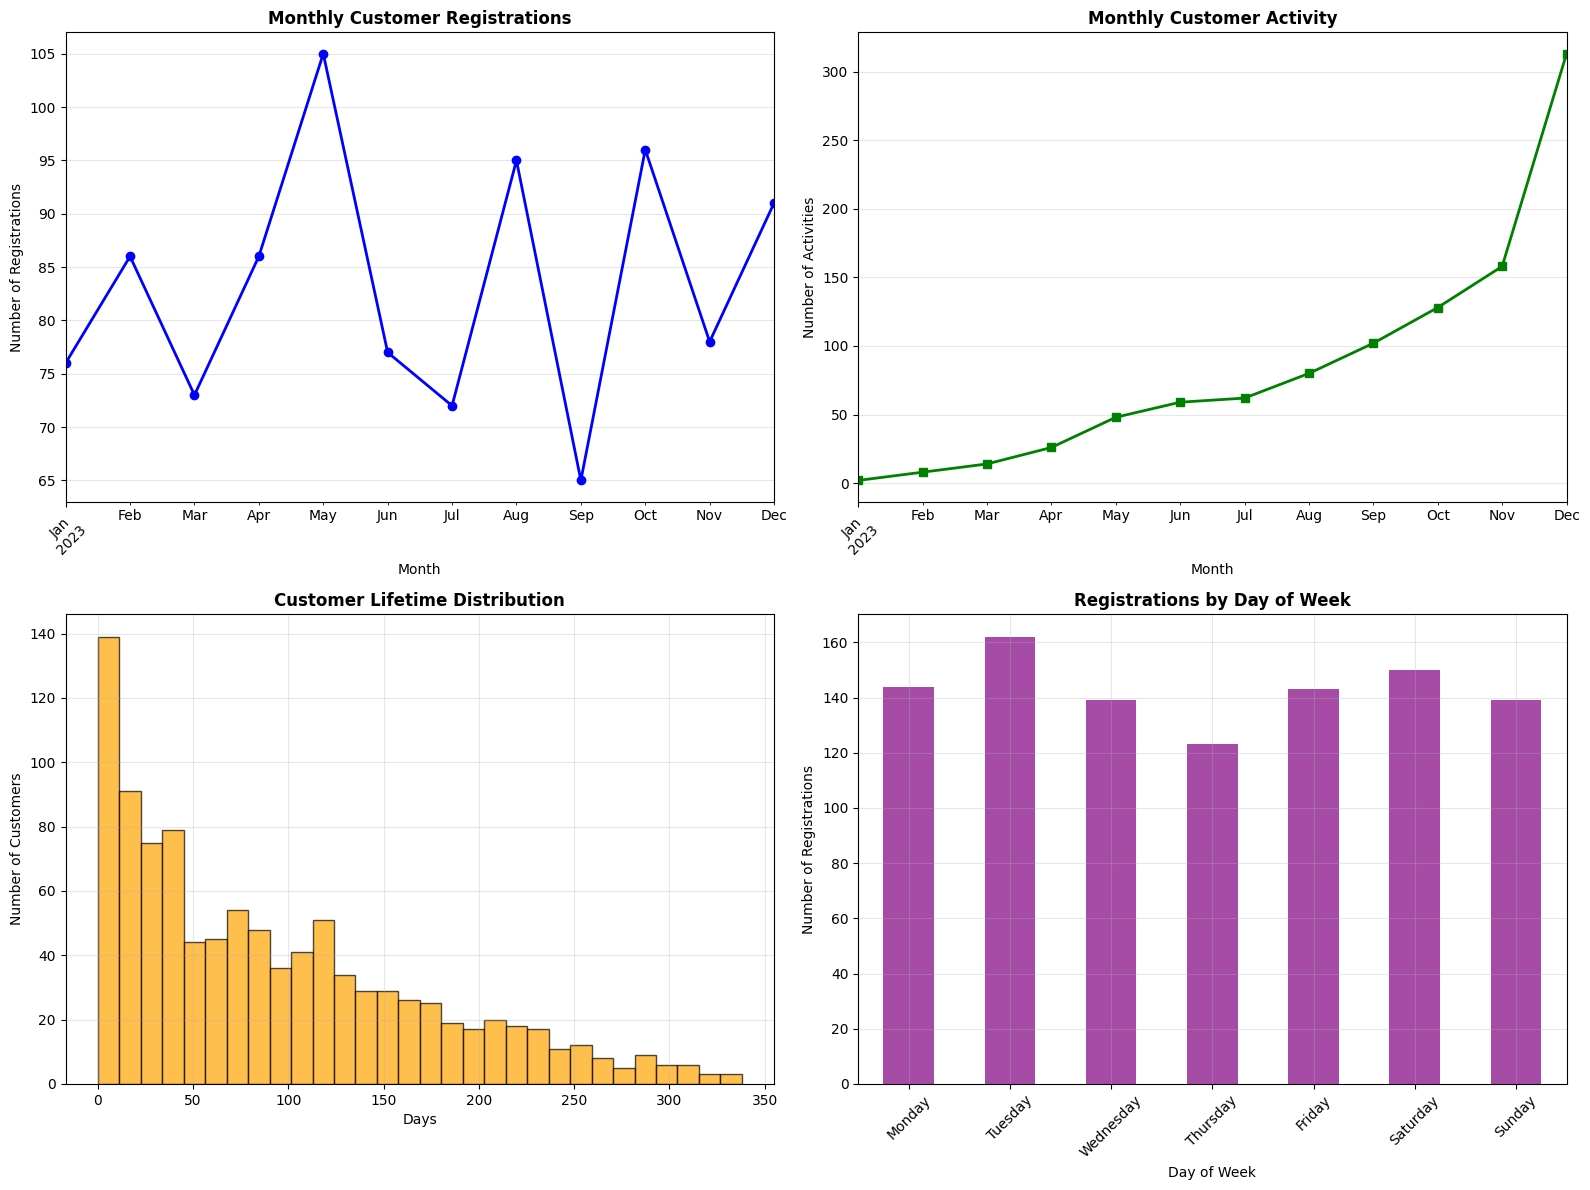


📊 TIME-BASED INSIGHTS:
----------------------------------------
Average customer lifetime: 92.0 days
Median customer lifetime: 73.0 days
Peak registration month: 2023-05
Peak activity month: 2023-12
Most popular registration day: Tuesday


In [16]:
# 6. Time-based Analysis
print("\n" + "=" * 60)
print("📅 TIME-BASED ANALYSIS")
print("=" * 60)

# Convert dates to datetime if they're not already
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['last_activity'] = pd.to_datetime(df['last_activity'])

# Create monthly registration trends
df['registration_month'] = df['registration_date'].dt.to_period('M')
monthly_registrations = df['registration_month'].value_counts().sort_index()

# Create monthly activity trends
df['activity_month'] = df['last_activity'].dt.to_period('M')
monthly_activity = df['activity_month'].value_counts().sort_index()

# Plot time-based trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly registrations
monthly_registrations.plot(kind='line', ax=axes[0,0], marker='o', color='blue', linewidth=2)
axes[0,0].set_title('Monthly Customer Registrations', fontweight='bold')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Number of Registrations')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Monthly activity
monthly_activity.plot(kind='line', ax=axes[0,1], marker='s', color='green', linewidth=2)
axes[0,1].set_title('Monthly Customer Activity', fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Activities')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# Customer lifetime (days between registration and last activity)
df['customer_lifetime_days'] = (df['last_activity'] - df['registration_date']).dt.days
df['customer_lifetime_days'].hist(bins=30, ax=axes[1,0], color='orange', alpha=0.7, edgecolor='black')
axes[1,0].set_title('Customer Lifetime Distribution', fontweight='bold')
axes[1,0].set_xlabel('Days')
axes[1,0].set_ylabel('Number of Customers')
axes[1,0].grid(True, alpha=0.3)

# Registration by day of week
df['registration_dow'] = df['registration_date'].dt.day_name()
dow_registrations = df['registration_dow'].value_counts()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_registrations = dow_registrations.reindex(dow_order)
dow_registrations.plot(kind='bar', ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('Registrations by Day of Week', fontweight='bold')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Number of Registrations')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display time-based insights
print("\n📊 TIME-BASED INSIGHTS:")
print("-" * 40)
print(f"Average customer lifetime: {df['customer_lifetime_days'].mean():.1f} days")
print(f"Median customer lifetime: {df['customer_lifetime_days'].median():.1f} days")
print(f"Peak registration month: {monthly_registrations.idxmax()}")
print(f"Peak activity month: {monthly_activity.idxmax()}")
print(f"Most popular registration day: {dow_registrations.idxmax()}")


## Summary Statistics

Comprehensive summary statistics, business metrics, and key insights from the customer behavior analysis.


In [17]:
# 1. Executive Summary Statistics
print("=" * 80)
print("📊 EXECUTIVE SUMMARY - CUSTOMER BEHAVIOR ANALYTICS")
print("=" * 80)

# Key Business Metrics
total_customers = len(df)
total_revenue = df['total_spent'].sum() if 'total_spent' in df.columns else 0
avg_revenue_per_customer = df['total_spent'].mean() if 'total_spent' in df.columns else 0
median_revenue_per_customer = df['total_spent'].median() if 'total_spent' in df.columns else 0
total_purchases = df['total_purchases'].sum() if 'total_purchases' in df.columns else 0
avg_purchases_per_customer = df['total_purchases'].mean() if 'total_purchases' in df.columns else 0
avg_satisfaction = df['satisfaction_score'].mean() if 'satisfaction_score' in df.columns else 0
avg_session_duration = df['avg_session_duration'].mean() if 'avg_session_duration' in df.columns else 0

print(f"👥 Total Customers: {total_customers:,}")
print(f"💰 Total Revenue: ${total_revenue:,.2f}")
print(f"💵 Average Revenue per Customer: ${avg_revenue_per_customer:.2f}")
print(f"📊 Median Revenue per Customer: ${median_revenue_per_customer:.2f}")
print(f"🛒 Total Purchases: {total_purchases:,}")
print(f"🛍️  Average Purchases per Customer: {avg_purchases_per_customer:.1f}")
print(f"😊 Average Satisfaction Score: {avg_satisfaction:.1f}/10")
print(f"⏱️  Average Session Duration: {avg_session_duration:.1f} minutes")
print()

# Customer Demographics Summary
print("👥 CUSTOMER DEMOGRAPHICS:")
print("-" * 40)
if 'age' in df.columns:
    print(f"Average Age: {df['age'].mean():.1f} years")
    print(f"Age Range: {df['age'].min()} - {df['age'].max()} years")
else:
    print("Age data not available")

if 'gender' in df.columns:
    print(f"Gender Distribution:")
    gender_dist = df['gender'].value_counts()
    for gender, count in gender_dist.items():
        percentage = (count / total_customers) * 100
        print(f"  {gender}: {count} ({percentage:.1f}%)")
else:
    print("Gender data not available")

if 'city' in df.columns:
    print(f"\nTop 3 Cities by Customer Count:")
    city_dist = df['city'].value_counts().head(3)
    for city, count in city_dist.items():
        percentage = (count / total_customers) * 100
        print(f"  {city}: {count} ({percentage:.1f}%)")
else:
    print("City data not available")


📊 EXECUTIVE SUMMARY - CUSTOMER BEHAVIOR ANALYTICS
👥 Total Customers: 1,000
💰 Total Revenue: $336,309.32
💵 Average Revenue per Customer: $336.31
📊 Median Revenue per Customer: $330.60
🛒 Total Purchases: 6,564
🛍️  Average Purchases per Customer: 6.6
😊 Average Satisfaction Score: 5.3/10
⏱️  Average Session Duration: 14.4 minutes

👥 CUSTOMER DEMOGRAPHICS:
----------------------------------------
Average Age: 44.9 years
Age Range: 18 - 80 years
Gender Distribution:
  F: 525 (52.5%)
  M: 383 (38.3%)
  Other: 92 (9.2%)

Top 3 Cities by Customer Count:
  Lausanne: 180 (18.0%)
  Basel: 173 (17.3%)
  Zurich: 173 (17.3%)


In [18]:
# 2. Business Performance Metrics
print("\n" + "=" * 80)
print("📈 BUSINESS PERFORMANCE METRICS")
print("=" * 80)

# Revenue Analysis
print("💰 REVENUE ANALYSIS:")
print("-" * 30)
revenue_by_subscription = df.groupby('subscription_type')['total_spent'].agg(['sum', 'mean', 'count'])
revenue_by_subscription.columns = ['Total Revenue', 'Avg Revenue per Customer', 'Customer Count']
revenue_by_subscription['Revenue Share %'] = (revenue_by_subscription['Total Revenue'] / total_revenue * 100).round(1)
display(revenue_by_subscription)

# Top performing segments
print(f"\n🏆 TOP PERFORMING SEGMENTS:")
print("-" * 40)
print("Highest Revenue Cities:")
top_cities = df.groupby('city')['total_spent'].sum().sort_values(ascending=False).head(3)
for city, revenue in top_cities.items():
    print(f"  {city}: ${revenue:,.2f}")

print("\nHighest Revenue Age Segments:")
top_age_segments = df.groupby('age_segment')['total_spent'].sum().sort_values(ascending=False).head(3)
for segment, revenue in top_age_segments.items():
    print(f"  {segment}: ${revenue:,.2f}")

print("\nHighest Revenue Device Types:")
top_devices = df.groupby('device_type')['total_spent'].sum().sort_values(ascending=False)
for device, revenue in top_devices.items():
    print(f"  {device}: ${revenue:,.2f}")

# Customer Engagement Metrics
print(f"\n📱 CUSTOMER ENGAGEMENT METRICS:")
print("-" * 40)
print(f"Average Page Views per Session: {df['page_views_per_session'].mean():.1f}")
print(f"Average Bounce Rate: {df['bounce_rate'].mean():.3f} ({df['bounce_rate'].mean()*100:.1f}%)")
print(f"Average Support Tickets per Customer: {df['support_tickets'].mean():.2f}")

# High-value customer identification
high_value_threshold = df['total_spent'].quantile(0.9)
high_value_customers = df[df['total_spent'] >= high_value_threshold]
print(f"\n💎 HIGH-VALUE CUSTOMERS (Top 10%):")
print("-" * 40)
print(f"Count: {len(high_value_customers)} customers")
print(f"Average Spending: ${high_value_customers['total_spent'].mean():.2f}")
print(f"Average Satisfaction: {high_value_customers['satisfaction_score'].mean():.1f}/10")
print(f"Most Common Subscription: {high_value_customers['subscription_type'].mode().iloc[0]}")
print(f"Most Common Device: {high_value_customers['device_type'].mode().iloc[0]}")



📈 BUSINESS PERFORMANCE METRICS
💰 REVENUE ANALYSIS:
------------------------------


,Total Revenue,Avg Revenue per Customer,Customer Count,Revenue Share %
subscription_type,,,,
Basic,83704.266203,233.159516,359,24.9
Enterprise,112066.736798,441.207625,254,33.3
Premium,140538.318856,363.148111,387,41.8



🏆 TOP PERFORMING SEGMENTS:
----------------------------------------
Highest Revenue Cities:
  Lausanne: $62,658.90
  Zurich: $58,503.16
  Bern: $56,314.14

Highest Revenue Age Segments:
  36-50: $135,530.63
  51-65: $90,715.75
  26-35: $47,208.24

Highest Revenue Device Types:
  Mobile: $209,920.75
  Desktop: $91,391.77
  Tablet: $34,996.81

📱 CUSTOMER ENGAGEMENT METRICS:
----------------------------------------
Average Page Views per Session: 11.1
Average Bounce Rate: 0.246 (24.6%)
Average Support Tickets per Customer: 1.27

💎 HIGH-VALUE CUSTOMERS (Top 10%):
----------------------------------------
Count: 100 customers
Average Spending: $530.17
Average Satisfaction: 5.4/10
Most Common Subscription: Enterprise
Most Common Device: Mobile


In [19]:
# 3. Key Insights and Business Recommendations
print("\n" + "=" * 80)
print("💡 KEY INSIGHTS AND BUSINESS RECOMMENDATIONS")
print("=" * 80)

# Customer behavior insights
print("🎯 CUSTOMER BEHAVIOR INSIGHTS:")
print("-" * 40)

# Spending behavior
high_spenders = df[df['total_spent'] > df['total_spent'].quantile(0.75)]
low_spenders = df[df['total_spent'] < df['total_spent'].quantile(0.25)]

print(f"• High Spenders (Top 25%) vs Low Spenders (Bottom 25%):")
print(f"  - High Spenders: {len(high_spenders)} customers, Avg: ${high_spenders['total_spent'].mean():.2f}")
print(f"  - Low Spenders: {len(low_spenders)} customers, Avg: ${low_spenders['total_spent'].mean():.2f}")
print(f"  - Spending Ratio: {high_spenders['total_spent'].mean() / low_spenders['total_spent'].mean():.1f}x")

# Engagement patterns
print(f"\n• Engagement Patterns:")
print(f"  - High Engagement (Long Sessions): {len(df[df['avg_session_duration'] > df['avg_session_duration'].quantile(0.75)])} customers")
print(f"  - Low Engagement (Short Sessions): {len(df[df['avg_session_duration'] < df['avg_session_duration'].quantile(0.25)])} customers")
print(f"  - High Bounce Rate (>50%): {len(df[df['bounce_rate'] > 0.5])} customers ({len(df[df['bounce_rate'] > 0.5])/len(df)*100:.1f}%)")

# Satisfaction analysis
print(f"\n• Satisfaction Analysis:")
satisfied_customers = df[df['satisfaction_score'] >= 8]
dissatisfied_customers = df[df['satisfaction_score'] <= 4]
print(f"  - Satisfied Customers (8+): {len(satisfied_customers)} ({len(satisfied_customers)/len(df)*100:.1f}%)")
print(f"  - Dissatisfied Customers (≤4): {len(dissatisfied_customers)} ({len(dissatisfied_customers)/len(df)*100:.1f}%)")

# Business Recommendations
print(f"\n📋 STRATEGIC RECOMMENDATIONS:")
print("-" * 40)

# Revenue optimization
print("💰 REVENUE OPTIMIZATION:")
print("1. Focus on High-Value Customer Segments:")
print(f"   • Target customers with {high_value_customers['subscription_type'].mode().iloc[0]} subscriptions")
print(f"   • Prioritize {high_value_customers['device_type'].mode().iloc[0]} users for premium features")
print(f"   • Implement VIP programs for top {len(high_value_customers)} customers")

# Subscription strategy
best_subscription = df.groupby('subscription_type')['total_spent'].mean().idxmax()
print(f"\n2. Subscription Strategy:")
print(f"   • Promote {best_subscription} subscription as it shows highest average spending")
print(f"   • Create upgrade incentives for Basic → Premium customers")
print(f"   • Develop Enterprise features based on high-value customer needs")

# Geographic expansion
top_city = df.groupby('city')['total_spent'].mean().idxmax()
print(f"\n3. Geographic Expansion:")
print(f"   • Expand marketing efforts in {top_city} (highest avg spending)")
print(f"   • Replicate successful strategies from top-performing cities")
print(f"   • Consider local partnerships in high-value markets")

# Customer experience
print(f"\n4. Customer Experience Improvements:")
print(f"   • Address high bounce rate ({len(df[df['bounce_rate'] > 0.5])/len(df)*100:.1f}% of customers)")
print(f"   • Improve session duration for better engagement")
print(f"   • Implement satisfaction surveys for customers scoring ≤4")

# Engagement optimization
print(f"\n5. Engagement Optimization:")
print(f"   • Develop mobile-first features (60% mobile users)")
print(f"   • Create personalized content based on age segments")
print(f"   • Implement loyalty programs for repeat customers")

print(f"\n📊 SUCCESS METRICS TO TRACK:")
print("-" * 40)
print("• Customer Lifetime Value (CLV)")
print("• Monthly Recurring Revenue (MRR)")
print("• Customer Acquisition Cost (CAC)")
print("• Churn Rate by segment")
print("• Net Promoter Score (NPS)")
print("• Average Revenue Per User (ARPU)")



💡 KEY INSIGHTS AND BUSINESS RECOMMENDATIONS
🎯 CUSTOMER BEHAVIOR INSIGHTS:
----------------------------------------
• High Spenders (Top 25%) vs Low Spenders (Bottom 25%):
  - High Spenders: 250 customers, Avg: $476.34
  - Low Spenders: 250 customers, Avg: $205.97
  - Spending Ratio: 2.3x

• Engagement Patterns:
  - High Engagement (Long Sessions): 250 customers
  - Low Engagement (Short Sessions): 250 customers
  - High Bounce Rate (>50%): 48 customers (4.8%)

• Satisfaction Analysis:
  - Satisfied Customers (8+): 35 (3.5%)
  - Dissatisfied Customers (≤4): 182 (18.2%)

📋 STRATEGIC RECOMMENDATIONS:
----------------------------------------
💰 REVENUE OPTIMIZATION:
1. Focus on High-Value Customer Segments:
   • Target customers with Enterprise subscriptions
   • Prioritize Mobile users for premium features
   • Implement VIP programs for top 100 customers

2. Subscription Strategy:
   • Promote Enterprise subscription as it shows highest average spending
   • Create upgrade incentives for


📊 FINAL SUMMARY DASHBOARD


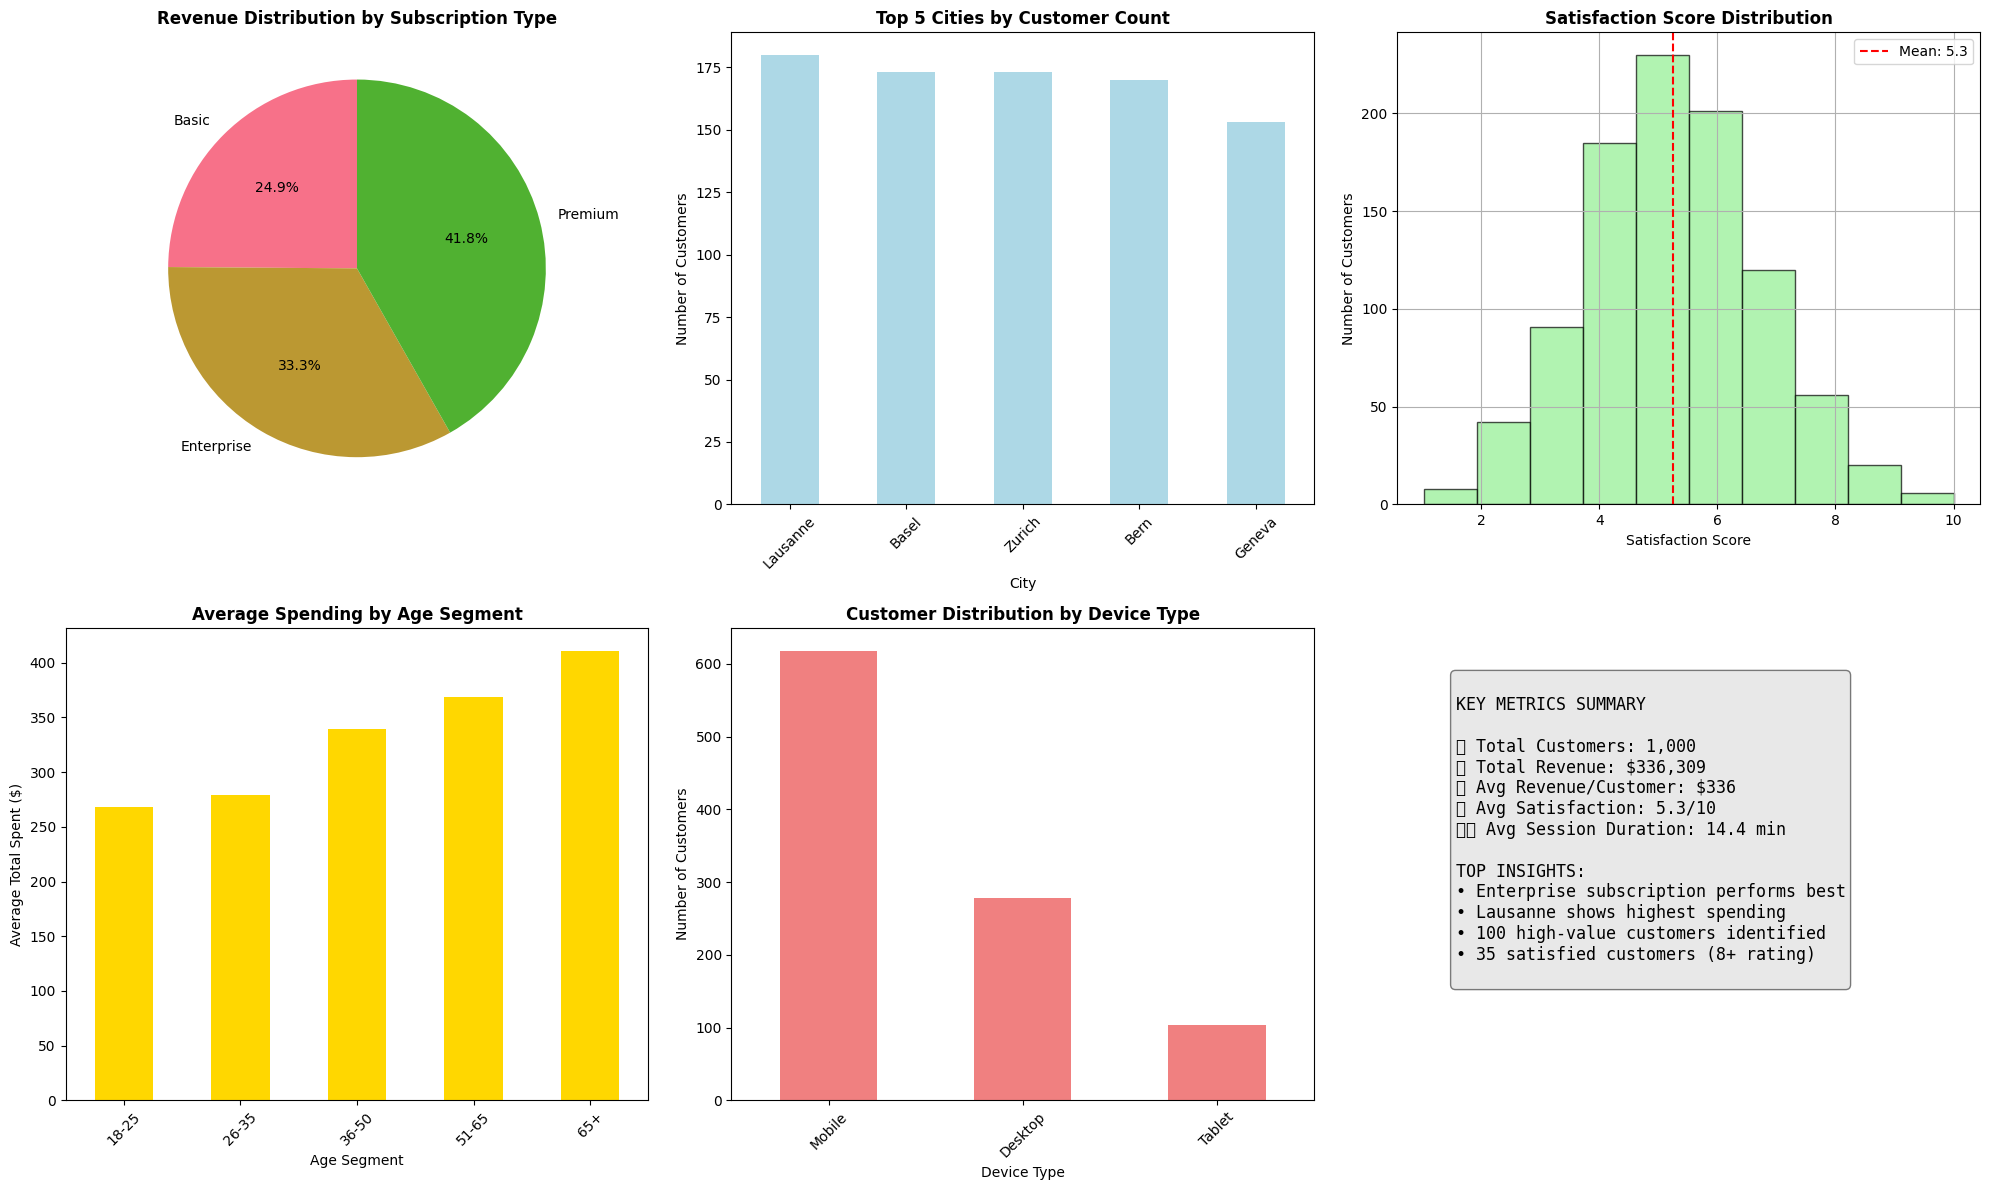

✅ DATA EXPLORATION COMPLETE!
🎉 Your comprehensive customer behavior analysis is ready!
📈 Use these insights to drive data-driven business decisions!


In [20]:
# 4. Final Summary Dashboard
print("\n" + "=" * 80)
print("📊 FINAL SUMMARY DASHBOARD")
print("=" * 80)

# Create a summary dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Revenue by Subscription Type
revenue_by_sub = df.groupby('subscription_type')['total_spent'].sum()
revenue_by_sub.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Revenue Distribution by Subscription Type', fontweight='bold')
axes[0,0].set_ylabel('')

# 2. Customer Count by City
city_counts = df['city'].value_counts().head(5)
city_counts.plot(kind='bar', ax=axes[0,1], color='lightblue')
axes[0,1].set_title('Top 5 Cities by Customer Count', fontweight='bold')
axes[0,1].set_xlabel('City')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Satisfaction Score Distribution
df['satisfaction_score'].hist(bins=10, ax=axes[0,2], color='lightgreen', alpha=0.7, edgecolor='black')
axes[0,2].set_title('Satisfaction Score Distribution', fontweight='bold')
axes[0,2].set_xlabel('Satisfaction Score')
axes[0,2].set_ylabel('Number of Customers')
axes[0,2].axvline(df['satisfaction_score'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["satisfaction_score"].mean():.1f}')
axes[0,2].legend()

# 4. Spending by Age Segment
age_spending = df.groupby('age_segment')['total_spent'].mean()
age_spending.plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('Average Spending by Age Segment', fontweight='bold')
axes[1,0].set_xlabel('Age Segment')
axes[1,0].set_ylabel('Average Total Spent ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Device Type Distribution
device_counts = df['device_type'].value_counts()
device_counts.plot(kind='bar', ax=axes[1,1], color='lightcoral')
axes[1,1].set_title('Customer Distribution by Device Type', fontweight='bold')
axes[1,1].set_xlabel('Device Type')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Key Metrics Summary
axes[1,2].axis('off')
summary_text = f"""
KEY METRICS SUMMARY

👥 Total Customers: {total_customers:,}
💰 Total Revenue: ${total_revenue:,.0f}
💵 Avg Revenue/Customer: ${avg_revenue_per_customer:.0f}
😊 Avg Satisfaction: {avg_satisfaction:.1f}/10
⏱️ Avg Session Duration: {avg_session_duration:.1f} min

TOP INSIGHTS:
• {best_subscription} subscription performs best
• {top_city} shows highest spending
• {len(high_value_customers)} high-value customers identified
• {len(satisfied_customers)} satisfied customers (8+ rating)
"""

axes[1,2].text(0.1, 0.9, summary_text, transform=axes[1,2].transAxes, 
               fontsize=12, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.show()

print("✅ DATA EXPLORATION COMPLETE!")
print("🎉 Your comprehensive customer behavior analysis is ready!")
print("📈 Use these insights to drive data-driven business decisions!")
